# NTS Data




In [37]:
import random

from scipy.stats import norm
import numpy as np
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from pathlib import Path

from caveat.evaluate.describe import features
from caveat.evaluate.describe.times import (
    joint_time_distributions_plot,
    times_distributions_plot,
)
from caveat.evaluate.describe.transitions import sequence_prob_plot
from caveat.evaluate.distance import mape, emd
from caveat.evaluate.features import participation, times

In [38]:
def filter_on(attributes, schedules, on):
    values = attributes[on].value_counts()
    selected = {}
    for value in values.index:
        pids = attributes[attributes[on] == value]["pid"]
        selected[value] = schedules[schedules["pid"].isin(pids)]
    return selected


def participation_table(schedules, groups):
    participation_rates = {
        ("observed", "all"): schedules.act.value_counts(normalize=True)
    }
    for name, group in groups.items():
        for key, data in group.items():
            participation_rates[(name, key)] = data.act.value_counts(
                normalize=True
            )

    return pd.DataFrame(participation_rates)


cmap1 = {"employed": "royalblue", "unemployed": "gray", "student": "salmon"}


def plot_z(zs, attributes, figsize=(10, 6), groups=True):
    fig, axs = plt.subplots(1, len(zs), figsize=figsize)
    if len(zs) > 1:
        axs = axs.flatten()
    else:
        axs = [axs]
    for ax, (name, data) in zip(axs, zs.items()):
        atts = attributes[name]
        if groups:
            colors = list(atts.work_status.map(cmap1))
        else:
            colors = None
        ax.set_title(name)
        # ax.set_xlabel("z1")
        # ax.set_ylabel("z2")
        ax.scatter(data.loc[:, 0], data.loc[:, 1], alpha=0.5, s=1, c=colors)
    return fig


cmap = {
    "home": "bisque",
    "work": "royalblue",
    "education": "salmon",
    "other": "gray",
}

In [39]:
attributes = pd.read_csv("../tmp/nts_home_attributes.csv")
schedules = pd.read_csv("../tmp/nts_home_schedules.csv")

In [45]:
# load vae
synth_path = Path("../logs/mmrun_warm")
synthetic_attributes = pd.read_csv(
    synth_path / "version_0/synthetic_attributes.csv"
)
vaes = {
    "combined": pd.read_csv(synth_path / "version_0/synthetic_schedules.csv"),
    "employed": pd.read_csv(
        synth_path / "work_status-employed/version_0/synthetic_schedules.csv"
    ),
    "unemployed": pd.read_csv(
        synth_path / "work_status-unemployed/version_0/synthetic_schedules.csv"
    ),
    "student": pd.read_csv(
        synth_path / "work_status-student/version_0/synthetic_schedules.csv"
    ),
}


vae_work_status_groups = {
    k: filter_on(synthetic_attributes, v, "work_status")
    for k, v in vaes.items()
}
vae_work_status_groups["observed"] = filter_on(
    attributes, schedules, "work_status"
)


vae_zs = {
    "employed": pd.read_csv(
        synth_path / "work_status-employed/version_0/test_inference/zs.csv",
        header=None,
    ),
    "unemployed": pd.read_csv(
        synth_path / "work_status-unemployed/version_0/test_inference/zs.csv",
        header=None,
    ),
    "student": pd.read_csv(
        synth_path / "work_status-student/version_0/test_inference/zs.csv",
        header=None,
    ),
}
vae_attributes = {
    "employed": pd.read_csv(
        synth_path
        / "work_status-employed/version_0/test_inference/input_attributes.csv"
    ),
    "unemployed": pd.read_csv(
        synth_path
        / "work_status-unemployed/version_0/test_inference/input_attributes.csv"
    ),
    "student": pd.read_csv(
        synth_path
        / "work_status-student/version_0/test_inference/input_attributes.csv"
    ),
}

df = participation_table(schedules, vae_work_status_groups).T
df["work"].unstack(-1)

,all,employed,student,unemployed
combined,NaN,0.050193,0.001613,0.013027
employed,NaN,0.050193,NaN,NaN
observed,0.069052,0.126750,0.015847,0.001159
student,NaN,0.001613,NaN,NaN
unemployed,NaN,0.013027,NaN,NaN


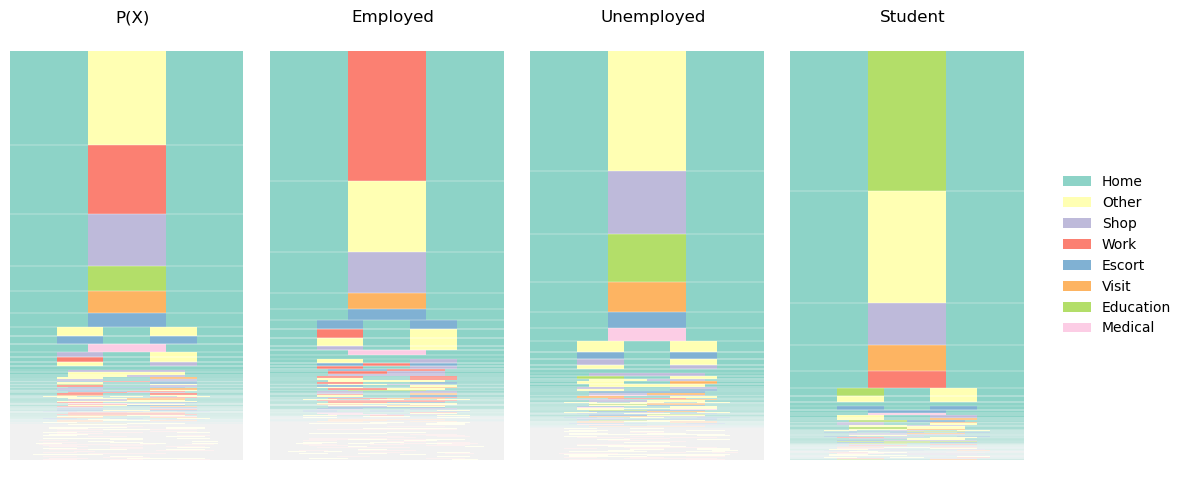

In [41]:
fig = sequence_prob_plot(
    schedules,
    ys=vae_work_status_groups["observed"],
    # cmap=cmap,
    observed_title="P(X)",
)

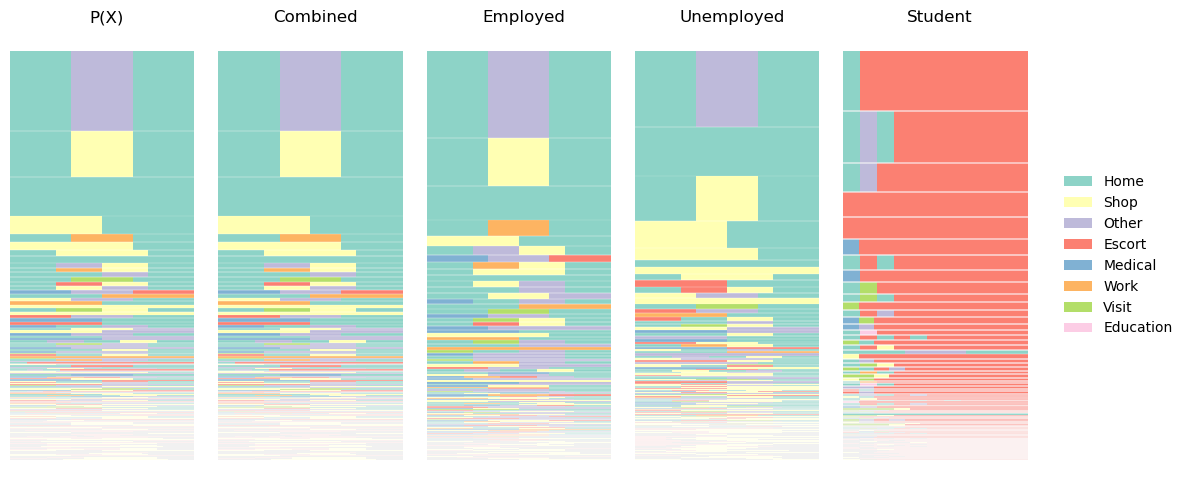

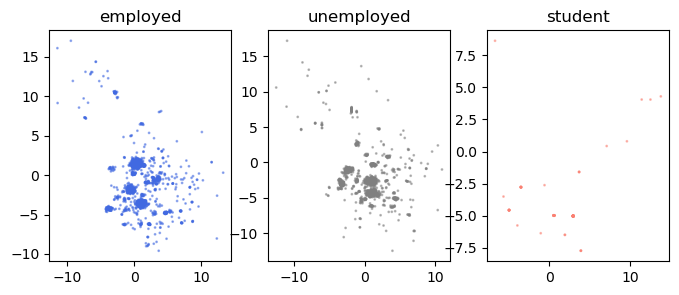

In [46]:
# vaes

fig = sequence_prob_plot(
    vaes["combined"],
    vaes,
    # cmap=cmap,
    observed_title="P(X)",
)

fig = plot_z(vae_zs, vae_attributes, figsize=(8, 3), groups=True)

In [ ]:
import pickle

import pandas as pd
import torch
from pytorch_lightning import Trainer

from caveat import models
from caveat.data import build_custom_gen_dataloader


class Generator:
    def __init__(
        self, ckpt_path, schedule_encoder_path, attributes_encoder_path
    ) -> None:
        # load model from checkpoint
        self.model = models.sequence.cvae_sequence_lstm_nudger_adversarial.CVAESeqLSTMNudgerAdversarial.load_from_checkpoint(
            ckpt_path
        )

        # load encoders
        with open(schedule_encoder_path, "rb") as f:
            self.schedule_encoder = pickle.load(f)

        with open(attributes_encoder_path, "rb") as f:
            self.attributes_encoder = pickle.load(f)

        self.ckpt_path = ckpt_path
        self.trainer = Trainer()

    def __call__(self, synthetics):
        return self.gen(synthetics)

    # def gen(self, synthetics):
    #     return trim(stretch(pad(self._gen(synthetics))))

    def _gen(self, synthetics, z):
        synthetic_conditionals = self.attributes_encoder.encode(synthetics)

        dataloader = build_custom_gen_dataloader(
            synthetic_conditionals, z, max(len(synthetic_conditionals), 256)
        )

        res = self.trainer.predict(
            model=self.model, ckpt_path=self.ckpt_path, dataloaders=dataloader
        )
        ys, res, zs = zip(*res)

        schedules = self.schedule_encoder.decode(torch.concat(res))
        return schedules


synthetics = pd.DataFrame(
    [
        {"work_status": "employed"},
        {"work_status": "unemployed"},
        {"work_status": "student"},
    ]
)
zs = torch.Tensor([[-0.5] * 6] * 3)
gen_path = synth_path / "CVAESeqLSTM_6x6x512_kld001_adv10/version_0"
Generator(
    ckpt_path=gen_path / "checkpoints/epoch=12-step=1716.ckpt",
    schedule_encoder_path=gen_path / "schedule_encoder.pkl",
    attributes_encoder_path=gen_path / "attribute_encoder.pkl",
)._gen(synthetics, zs)

FileNotFoundError: [Errno 2] No such file or directory: 'c:/Users/fred/Projects/caveat/logs/mmrun_warm/CVAESeqLSTM_6x6x512_kld001_adv10/version_0/checkpoints/epoch=12-step=1716.ckpt'

In [ ]:
attributes.work_status.value_counts()

In [ ]:
data = inferred_zs["kld005"]
atts = in_attributes["kld005"]
colors = list(
    atts.work_status.map(
        {"employed": "blue", "unemployed": "red", "student": "yellow"}
    )
)
fig = ax.scatter(data.loc[:, 0], data.loc[:, 1], alpha=1, s=0.3, c=colors)

In [ ]:
observed_work_status["unemployed"].act.value_counts()

In [ ]:
kld1_work_status["unemployed"].act.value_counts()

In [ ]:
def split(attributes, schedules):
    splits = {}
    splits["gender"] = filter_on(attributes, schedules, "gender")
    splits["age"] = filter_on(attributes, schedules, "age_group")
    splits["age"] = {
        i: splits["age"][i] for i in ["senior", "adult", "young adult", "child"]
    }
    splits["ethnicity"] = filter_on(attributes, schedules, "ethnicity")
    splits["education"] = filter_on(attributes, schedules, "education")
    splits["license"] = filter_on(attributes, schedules, "license")
    splits["car_access"] = filter_on(attributes, schedules, "car_access")
    splits["work"] = filter_on(attributes, schedules, "work_status")
    splits["area"] = filter_on(attributes, schedules, "area")
    splits["income"] = filter_on(attributes, schedules, "income_group")
    splits["income"] = {
        i: splits["income"][i]
        for i in ["highest", "high", "medium", "low", "lowest"]
    }
    splits["hh"] = filter_on(attributes, schedules, "hh_composition")
    splits["children"] = filter_on(attributes, schedules, "hh_children")
    splits["children"] = {
        i: splits["children"][i] for i in ["0", "1", "2", "3+"]
    }
    return splits


observed_splits = split(attributes, schedules)
cvae_splits = split(attributes, cvae)
vae_splits = split(attributes, vae)
rnn_splits = split(attributes, rnn)
kld0_splits = split(attributes, kld0)
kld1_splits = split(attributes, kld1)
kld100_splits = split(attributes, kld100)

In [ ]:
build_table(
    schedules,
    [
        gender_filtered,
        age_filtered,
        education_filtered,
        work_filtered,
        license_filtered,
        area_filtered,
        income_filtered,
    ],
    #   car_access_filtered, work_filtered, area_filtered, income_filtered],
    lambda x: features.average(times.start_times_by_act(x)),
)

In [ ]:
build_table(
    schedules,
    [
        gender_filtered,
        age_filtered,
        education_filtered,
        license_filtered,
        area_filtered,
        income_filtered,
    ],
    lambda x: features.sd(times.start_times_by_act(x)),
)

In [ ]:
fig = times_distributions_plot(schedules, work_filtered)

In [ ]:
def plot_times(
    subs,
    column="start",
    acts=None,
    normalise=False,
    minimum=0,
    maximum=1440,
    plot_width=10,
):
    if acts is None:
        acts = set()
        for data in subs.values():
            acts.update(set(data.act))

    print("acts: ", acts)

    splits = {
        k: extract_activities(v, column, minimum, maximum)
        for k, v in subs.items()
    }
    print(splits.keys())

    return plot_bins(
        splits,
        acts,
        column,
        normalise=normalise,
        minimum=minimum,
        maximum=maximum,
        width=plot_width,
    )


def extract_activities(schedules, column, minimum, maximum):
    if schedules.empty:
        return pd.DataFrame()
    data = schedules.copy()
    if minimum is not None:
        data = data[data[column] >= minimum]
    if maximum is not None:
        data = data[data[column] <= maximum]
    return pd.DataFrame(
        {
            "act": data.act,
            "start": (data.start).astype(int),
            "end": (data.end).astype(int),
            "duration": (data.duration).astype(int),
        }
    )


def plot_bins(
    splits,
    acts,
    column,
    width=10,
    height_factor=1.2,
    normalise=False,
    minimum=0,
    maximum=1440,
):
    fig, axs = plt.subplots(
        len(acts),
        figsize=(width, len(acts) * (len(splits) + 1) / 4),
        sharex=False,
    )
    if not isinstance(axs, np.ndarray):
        axs = [axs]

    mmhours = int(minimum / 60)
    mxhours = int(maximum / 60)
    duration = mxhours - mmhours
    step = 2

    for ax, act in zip(axs, acts):
        keys = list(splits.keys())
        n_keys = len(keys)
        binned = time_binner(splits, act, column, minimum, maximum)
        if normalise:
            binned = binned / binned.max()
        ax.pcolormesh(
            binned.T, cmap="gist_heat_r", edgecolors="white", linewidth=0.5
        )
        ax.xaxis.set_ticks([i for i in range(0, duration * 4 + 1, 8)])
        ax.set_xticklabels(
            [f"{h:02}:00" for h in range(mmhours, mxhours + 1, step)],
            size="small",
        )
        ax.yaxis.set_ticks([i + 0.5 for i in range(n_keys)])
        ax.yaxis.set_ticklabels(keys)
        ax.grid(which="minor", color="w", linestyle="-", linewidth=2)
        ax.tick_params(right=True, labelright=True)
        for pos in ["top", "bottom"]:
            ax.spines[pos].set_visible(False)
        ax.set_title(act.title(), fontsize="medium", rotation=0)

    fig.tight_layout()
    return fig


def time_binner(splits, act, column, minimum, maximum):
    """Bin start and end times and durations, return freq table for X hour period, 15min intervals."""
    bins = list(range(minimum, maximum + 1, 15))
    # bins[-1] = 100 * 60
    start = f"{int(minimum/60):02}:00:00"
    periods = int((maximum - minimum) / 15)
    labels = pd.timedelta_range(start=start, periods=periods, freq="15min")
    binned = pd.DataFrame(
        index=pd.timedelta_range(start=start, periods=periods, freq="15min")
    )
    for key, data in splits.items():
        if data.empty:
            continue
        split = data[data.act == act]
        if len(split) == 0:
            continue
        binned[key] = pd.cut(
            split[column], bins, labels=labels, right=False
        ).value_counts()

    return binned


def plot_times_compare(
    splits,
    column="start",
    acts=None,
    normalise=False,
    minimum=0,
    maximum=1440,
    plot_width=10,
):
    if acts is None:
        acts = set()
        for k, split in splits.items():
            for i, data in split.items():
                if data.empty:
                    continue
                acts.update(set(data.act))

    print("acts: ", acts)

    processed_splits = {}
    for name, split in splits.items():
        processed_splits[name] = {
            k: extract_activities(v, column, minimum, maximum)
            for k, v in split.items()
        }
    print(splits.keys())

    return plot_bins_compare(
        splits,
        acts,
        column,
        normalise=normalise,
        minimum=minimum,
        maximum=maximum,
        width=plot_width,
    )


def plot_bins_compare(
    splits,
    acts,
    column,
    width=10,
    height_factor=1.2,
    normalise=False,
    minimum=0,
    maximum=1440,
):
    fig = plt.figure(
        # constrained_layout=True,
        figsize=(width, len(acts) * (len(splits) + 1) * len(splits) / 4)
    )

    subfigs = fig.subfigures(len(acts), 1)
    mmhours = int(minimum / 60)
    mxhours = int(maximum / 60)
    duration = mxhours - mmhours
    step = 2

    for act, subfig in zip(acts, subfigs.flat):
        # subfig.suptitle(f'Subfig {outerind}')
        axs = subfig.subplots(len(splits), 1)
        for name, split, ax in zip(splits.keys(), splits.values(), axs.flat):
            ax.set_title(f"{name} {act}")
            keys = list(split.keys())
            n_keys = len(keys)
            binned = time_binner(split, act, column, minimum, maximum)
            if normalise:
                binned = binned / binned.max()
            ax.pcolormesh(
                binned.T, cmap="gist_heat_r", edgecolors="white", linewidth=0.5
            )
            ax.set_xticks([])
            ax.yaxis.set_ticks([i + 0.5 for i in range(n_keys)])
            ax.yaxis.set_ticklabels(keys)
            ax.grid(which="minor", color="w", linestyle="-", linewidth=2)
            ax.tick_params(right=True, labelright=True)
            for pos in ["top", "bottom"]:
                ax.spines[pos].set_visible(False)
            # ax.set_title(act.title(), fontsize="medium", rotation=0)
        ax.xaxis.set_ticks([i for i in range(0, duration * 4 + 1, 8)])
        ax.set_xticklabels(
            [f"{h:02}:00" for h in range(mmhours, mxhours + 1, step)],
            size="small",
        )

    # fig.tight_layout()
    return fig


fig = plot_times_compare(
    splits={
        "obs": observed_splits["work"],
        "kld0": kld0_splits["work"],
        "kld1": kld1_splits["work"],
    },
    acts=["home", "shop"],
    column="start",
    normalise=False,
    minimum=0,
    maximum=1440,
    plot_width=10,
)

In [ ]:
fig = plot_times_compare(
    splits={
        "obs": observed_splits["age"],
        "KLD1": KLD1_splits["age"],
        "KLD100": KLD100_splits["age"],
        "KLD10000": KLD10000_splits["age"],
    },
    column="start",
    normalise=False,
    minimum=0,
    maximum=1440,
    plot_width=10,
)

In [ ]:
fig = plot_times(
    observed_splits["work"],
    column="start",
    normalise=False,
    minimum=0,
    maximum=1440,
    plot_width=10,
)

In [ ]:
fig = plot_times(
    children_filtered,
    column="start",
    normalise=False,
    minimum=0,
    maximum=1440,
    plot_width=10,
)

In [ ]:
op = lambda x: features.average(participation.participation_rates_by_act(x))

build_table(
    schedules,
    [
        gender_filtered,
        age_filtered,
        education_filtered,
        license_filtered,
        area_filtered,
        income_filtered,
    ],
    op,
)

In [ ]:
fig = sequence_prob_plot(schedules, observed_splits["age"], figsize=(12, 4))

In [ ]:
fig = sequence_prob_plot(cvae, cvae_splits["work"], figsize=(12, 4))

In [ ]:
fig = sequence_prob_plot(schedules, education_filtered, figsize=(12, 4))

In [ ]:
fig = sequence_prob_plot(schedules, income_filtered, figsize=(12, 4))

In [ ]:
fig = sequence_prob_plot(schedules, area_filtered, figsize=(12, 4))

In [ ]:
fig = joint_time_distributions_plot(schedules, gender_filtered, figsize=(10, 6))

In [ ]:
fig = joint_time_distributions_plot(schedules, age_filtered, figsize=(10, 8))